In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def validate_inputs(y: tf.Tensor, mu: tf.Tensor, sigma: tf.Tensor, tau: tf.Tensor) -> None:
    """
    Validates the inputs to the skew_double_exponential_lpdf function.
    """
    tf.debugging.assert_all_finite(mu, message="Location parameter mu must be finite.")
    tf.debugging.assert_positive(sigma, message="Scale parameter sigma must be positive and finite.")
    tf.debugging.assert_greater_equal(tau, 0.0, message="Skewness parameter tau must be in the range [0, 1].")
    tf.debugging.assert_less_equal(tau, 1.0, message="Skewness parameter tau must be in the range [0, 1].")

    if tf.reduce_any(tf.math.is_nan(y)) or tf.reduce_any(tf.math.is_nan(mu)):
        raise ValueError("Random variable 'y' or location parameter 'mu' contains NaN values.")

In [5]:
def skew_double_exponential_lpdf(y: tf.Tensor, mu: tf.Tensor, sigma: tf.Tensor, tau: tf.Tensor) -> tf.Tensor:
    
    
    validate_inputs(y, mu, sigma, tau)

    inv_sigma = 1.0 / sigma
    y_m_mu = y - mu
    sign_diff = tf.sign(y_m_mu)

    is_negative_diff = tf.cast(sign_diff < 0, dtype=tf.float32)
    abs_diff_y_mu = tf.abs(y_m_mu)
    abs_diff_y_mu_scaled = abs_diff_y_mu * inv_sigma

    expo = (is_negative_diff + sign_diff * tau) * abs_diff_y_mu_scaled

    logp = -2.0 * expo
    logp += tf.math.log(2.0)
    logp -= tf.math.log(sigma)
    logp += tf.math.log(tau) + tf.math.log1p(-tau)

    deriv = 2.0 * (is_negative_diff + sign_diff * tau) * sign_diff * inv_sigma

    grad_y = -deriv
    grad_mu = deriv
    grad_sigma = -inv_sigma + 2.0 * expo * inv_sigma
    grad_tau = 1.0 / tau - 1.0 / (1.0 - tau) - sign_diff * 2.0 * abs_diff_y_mu_scaled

    return logp, grad_y, grad_mu, grad_sigma, grad_tau


In [28]:
y = tf.random.uniform([5000], minval=1.0, maxval=10, dtype=tf.float32)
mu = tf.constant(0.5, dtype=tf.float32)
sigma = tf.constant(1.2, dtype=tf.float32)
tau = tf.constant(0.5, dtype=tf.float32)

logp, grad_y, grad_mu, grad_sigma, grad_tau = skew_double_exponential_lpdf(y, mu, sigma, tau)

print(f"logp: {logp.numpy()}")
print(f"grad_y: {grad_y.numpy()}")
print(f"grad_mu: {grad_mu.numpy()}")
print(f"grad_sigma: {grad_sigma.numpy()}")
print(f"grad_tau: {grad_tau.numpy()}")

logp: [-8.544722  -7.585612  -3.7707396 ... -6.371914  -7.3308806 -1.4753177]
grad_y: [-0.8333333 -0.8333333 -0.8333333 ... -0.8333333 -0.8333333 -0.8333333]
grad_mu: [0.8333333 0.8333333 0.8333333 ... 0.8333333 0.8333333 0.8333333]
grad_sigma: [ 5.5577106   4.7584524   1.5793924  ...  3.7470376   4.5461764
 -0.33345917]
grad_tau: [-15.338507  -13.420286   -5.7905416 ... -10.99289   -12.910824
  -1.199698 ]


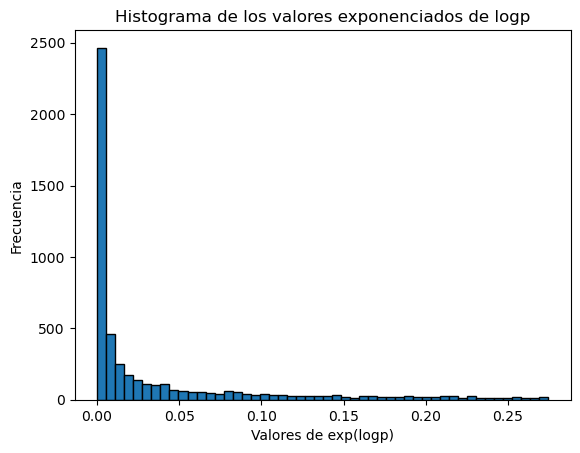

In [29]:
plt.hist(np.exp(logp), bins=50, edgecolor='black')
plt.title('Histograma de los valores exponenciados de logp')
plt.xlabel('Valores de exp(logp)')
plt.ylabel('Frecuencia')
plt.show()